# I. Apprentissage supervisé : Feature engineering et Classification

L’objectif dans cette partie est de construire un bon classifieur sur un jeu de données de crédit scoring du fichier "credit_scoring.csv" mis à disposition.

## 1. Chargement des données et préparation 

In [1]:
import numpy as np
np.set_printoptions(threshold=10000, suppress=True)
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')


Chargement du jeu de donnée 

In [2]:
df = pd.read_csv("credit_scoring.csv", sep=";")

In [3]:
print("=== Premières lignes du dataset ===\n")
print(df.head())

=== Premières lignes du dataset ===

   Seniority  Home  Time   Age  Marital  Records  Job  Expenses  Income  \
0        9.0   1.0  60.0  30.0      0.0      1.0  1.0      73.0   129.0   
1       17.0   1.0  60.0  58.0      1.0      1.0  0.0      48.0   131.0   
2       10.0   0.0  36.0  46.0      0.0      2.0  1.0      90.0   200.0   
3        0.0   1.0  60.0  24.0      1.0      1.0  0.0      63.0   182.0   
4        0.0   1.0  36.0  26.0      1.0      1.0  0.0      46.0   107.0   

   Assets  Debt  Amount   Price  Status  
0     0.0   0.0   800.0   846.0       1  
1     0.0   0.0  1000.0  1658.0       1  
2  3000.0   0.0  2000.0  2985.0       0  
3  2500.0   0.0   900.0  1325.0       1  
4     0.0   0.0   310.0   910.0       1  


Voici un echantillons du dataset nous avon donc 14 coulums qui represente des caracteristique d'un client. Rmq: la dernière column "Status" reprensente le fais d'avoir remboursé ou non le credit (qui par la suite sera le booléen à prédire ).

Nous allons maintenant transformer le jeu de données issue de pandas de type Data Frame en numpy Array
(c.f. values) puis par la suite séparer les variables caractéristiques de la variable à prédire (status) en deux tableaux différents.

In [4]:
array_data = df.values
X = array_data[:, :-1] # Toutes les colonnes sauf la dernière
Y = array_data[:, -1] # la dernière ici status 

Donc à partir d'ici nous avons:

- array_data : qui est le dataset complet mais de type ARRAY (pas DATAFRAME comme df),
- X qui est est constitué de array_data MAIS sans la column Status (la dernière),
- Y qui est seulement la derniere colomne (Status) de array_data


#### Analyse des propriétés

In [5]:
print(f"Taille de l'échantillon (X) : {X.shape}")
print(f"Nombre de Rows (X) : {X.shape[0]}")
print(f"Nombre de Columns (X) : {X.shape[1]}")
print(f"=========================================")
print(f"Taille de l'échantillon (Y) : {Y.shape}")
print(f"Nombre de Rows (Y) : {Y.shape[0]}")


Taille de l'échantillon (X) : (4375, 13)
Nombre de Rows (X) : 4375
Nombre de Columns (X) : 13
Taille de l'échantillon (Y) : (4375,)
Nombre de Rows (Y) : 4375


Normalize=True utilisé pour avoir les proportions (fréquences) 

In [6]:
pourcentage= df["Status"].value_counts(normalize=True).round(2)*100
print(pourcentage)

Status
1    72.0
0    28.0
Name: proportion, dtype: float64


Analyse :

Le Status 1 (bon payeur / crédit remboursé) représente 72 % des individus.

Le Status 0 (mauvais payeur / défaut) représente 28 %.

Pour éviter d’avoir un résultat biaisé du classifieur que nous allons construire, séparer les données
en deux parties (de taille 50% chacune) une dite d’apprentissage qui servira à l’apprentissage du
classifieur et l’autre dite de test qui servira à son évaluation (c.f. train_test_split avec un
random_state=1).

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=1)

In [8]:
print(f"===Verification===\n")

print("X_train :", X_train.shape)
print("X_test  :", X_test.shape)
print("y_train :", Y_train.shape)
print("y_test  :", Y_test.shape)

===Verification===

X_train : (2187, 13)
X_test  : (2188, 13)
y_train : (2187,)
y_test  : (2188,)


l'objectif est de diviser les tableaux X et Y en deux ensembles distincts de taille égale (50%):

-Train (Apprentissage) : Pour entraîner le modèle.

-Test (Évaluation) : Pour vérifier si le modèle fonctionne bien sur des données qu'il n'a jamais vues.

## 2. Apprentissage et évaluation de modèles :

Dans cette première étape, nous préparons les outils. Nous importons les métriques nécessaires de sklearn.metrics et nous définissons le dictionnaire contenant les trois algorithmes avec les paramètres demandés dans l'énoncé.

Nous allons donc definir 3 algorithmes de machine learning représentatifs de différentes approches. CART (Classification and Regression Trees) est un arbre de décision simple et interprétable qui segmente les données selon des règles hiérarchiques. KNN (K-Nearest Neighbors) est un algorithme basé sur la proximité qui classe chaque point selon la majorité de ses 5 plus proches voisins. Ainsi que MLP (Multi-Layer Perceptron) est un réseau de neurones artificiels à deux couches cachées (40 puis 20 neurones) capable de modéliser des relations non-linéaires complexes.

In [9]:
from utils import run_classifiers_train_test
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc

# Dictionnaire des algorithmes avec paramètres imposés
clfs = {
    'CART': DecisionTreeClassifier(random_state=1),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'MLP': MLPClassifier(hidden_layer_sizes=(40, 20), random_state=1)
}

Pour la fonction d'évaluation nous devons decidé entre la Précision qui indique parmi toutes les prédictions positives du modèle, quelle part était réellement positive (à privileger si on veut minimiser les faux-positifs) et le Rappel qui lui indique parmi toutes les valeurs positives réelles, quelle part a été correctement trouvée par le modèle (à privileger si on veut minimiser les faux négatifs).

Dans le contexte du Crédit Scoring, l'erreur la plus coûteuse est souvent d'accorder un crédit à quelqu'un qui ne remboursera pas (Faux Positif, si l'on considère la classe "Bon payeur" comme positive) ou de rater un mauvais payeur. Par consquent pour la suite nous allons privilégier la Précision.

Une haute précision signifie que lorsque le modèle dit "Accordez le crédit", il a très souvent raison. Cela minimise le risque financier direct (perte sèche d'argent prêté)

        La formule du score final sera donc : (Accuracy + Précision) / 2

où l'Accuracy represente le pourcentage total de prédictions correctes parmi toutes les prédictions.


remarque les fontion d’évaluation et run_classifiers_train_test sont dans le fichier "utils.py" 


Comparaison de 3 algorithmes...


>>> Evaluation du modèle : CART
Matrice de Confusion :
[[ 325  279]
 [ 318 1266]]
Accuracy  : 0.727
Précision : 0.819
Rappel    : 0.799
Score Final : 0.773


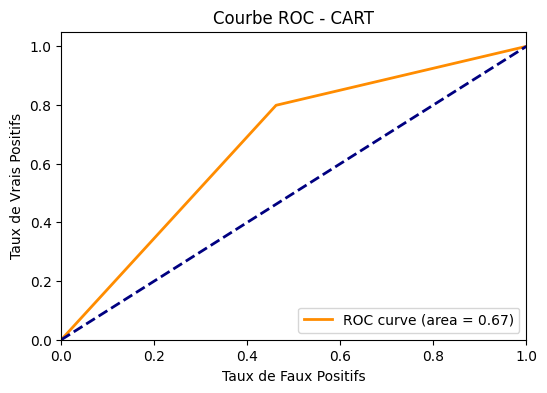


>>> Evaluation du modèle : KNN
Matrice de Confusion :
[[ 189  415]
 [ 187 1397]]
Accuracy  : 0.725
Précision : 0.771
Rappel    : 0.882
Score Final : 0.748


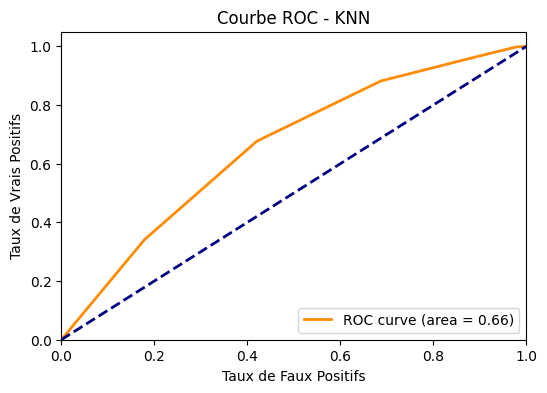


>>> Evaluation du modèle : MLP
Matrice de Confusion :
[[ 115  489]
 [  87 1497]]
Accuracy  : 0.737
Précision : 0.754
Rappel    : 0.945
Score Final : 0.745


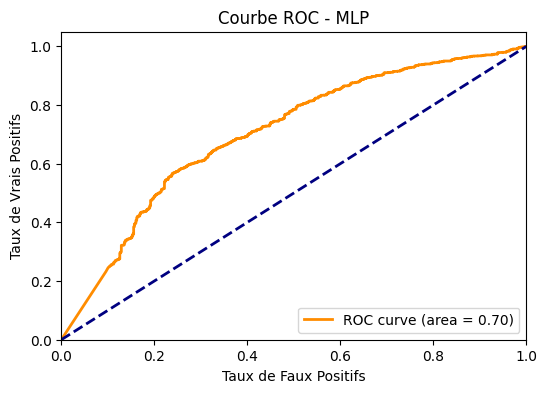

RESULTAT FINAL : Le meilleur modèle est CART avec un score de 0.773


In [10]:
models = run_classifiers_train_test(clfs, X_train, Y_train, X_test, Y_test)

### Interprétation des résultats et éxplications

Definition du contexte et variable: Donc ici nous utilisons des matrice de confusion representant (dans notre context): VN (vrai negatifs) qui reprensente les mauvais payeur correctement intercepter, FP (Faux Positifs) les Mauvais payeurs à qui on a prêté de l'argent par erreur (donc perte), FN (Faux Négatifs) qui sont les Bons payeurs qu'on a refusés par erreur (manque à gagner), ainsi que VP (Vrais Positifs) : Les Bons payeurs acceptés correctement.


Nous avons donc évalué à la fois l’accuracy, la précision et le rappel. Mais comme expliquer précedament avec notre contexte le critère le plus pertinent dans ce contexte est la précision, qui mesure la proportion de clients prédits comme fiables et qui le sont réellement. 

Le score final retenu correspond donc à la moyenne entre l’accuracy et la précision. Sur les données non normalisées, l’algorithme obtenant le meilleur score selon cette stratégie est l’arbre de décision CART (avec un score final de 0.773), qui se montre le plus efficace pour séparer correctement les bons et les mauvais payeurs dans ce premier scénario.

## 3. Normalisation des données avec StandardScaler

Certains algorithmes (comme le KNN ou le MLP) calculent des distances mathématiques. Si une variable varie entre 0 et 1 (ex: taux) et une autre entre 0 et 100 000 (ex: revenu), la seconde va "écraser" la première dans le calcul. La normalisation remet tout le monde sur un pied d'égalité. 

In [11]:
from sklearn.preprocessing import StandardScaler

# Init du Scaler
scaler = StandardScaler()

# methodo
# On calcule la moyenne et l'écart-type UNIQUEMENT sur le jeu d'apprentissage (fit)
# Puis on transforme les deux jeux de données avec ces mêmes paramètres.
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

Avec notre méthodologie : 

    Sur le TRAIN : On calcule la moyenne et l'écart-type, puis on applique la transformation. (fit puis transform).

    Sur le TEST : On interdit le recalcul. On utilise la moyenne et l'écart-type du train pour transformer le test. (transform seul).

=== LANCEMENT AVEC DONNÉES NORMALISÉES ===
Comparaison de 3 algorithmes...


>>> Evaluation du modèle : CART
Matrice de Confusion :
[[ 322  282]
 [ 315 1269]]
Accuracy  : 0.727
Précision : 0.818
Rappel    : 0.801
Score Final : 0.773


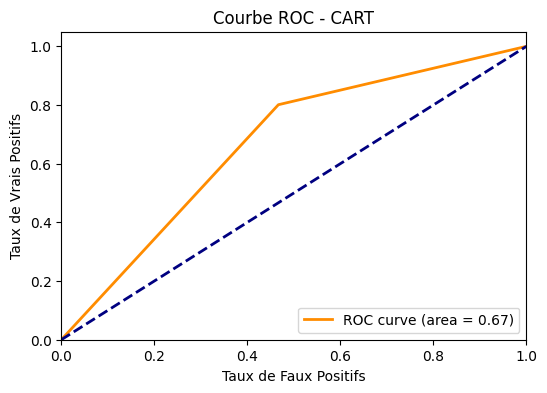


>>> Evaluation du modèle : KNN
Matrice de Confusion :
[[ 286  318]
 [ 223 1361]]
Accuracy  : 0.753
Précision : 0.811
Rappel    : 0.859
Score Final : 0.782


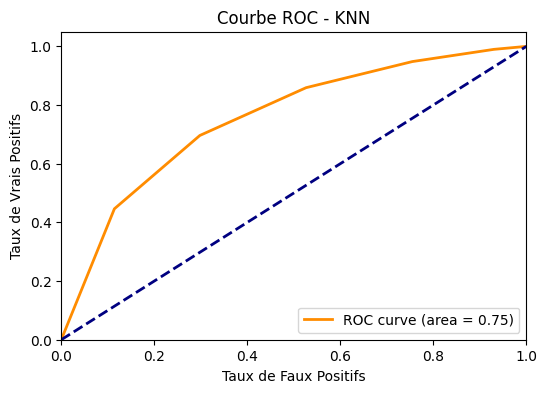


>>> Evaluation du modèle : MLP
Matrice de Confusion :
[[ 342  262]
 [ 227 1357]]
Accuracy  : 0.777
Précision : 0.838
Rappel    : 0.857
Score Final : 0.807


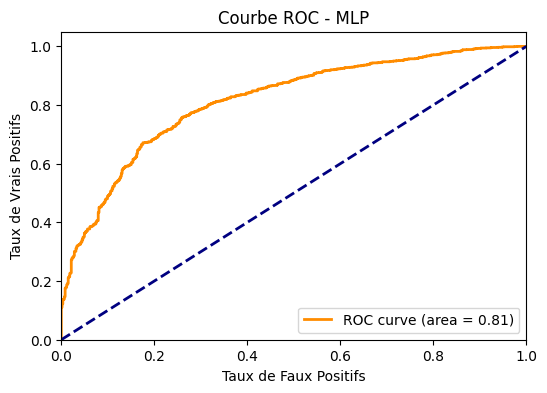

RESULTAT FINAL : Le meilleur modèle est MLP avec un score de 0.807


In [12]:
print("=== LANCEMENT AVEC DONNÉES NORMALISÉES ===")
algo_scaled= run_classifiers_train_test(clfs, X_train_scaled, Y_train, X_test_scaled, Y_test)

### Interprétation des résultats et éxplications

Après avoir appliqué une normalisation standard sur les variables continues, nous avons réexécuté la même procédure d’évaluation que précédemment. Les résultats montrent que la normalisation a un impact significatif sur certains algorithmes, notamment le KNN et le MLP, qui sont sensibles à l’échelle des données. Deplus on remarque que le CART à des résultats qui sont quasiment les mêmes. En effet du à son fonctionement la normalisation n'etait pas cencé impacter ces resultat. (prévisisble vu précedament)

En conclusion le MLP voit ses performances fortement augmenter et devient le meilleur modèle après normalisation, avec une précision nettement supérieurs et un score de 0.807

On remarque que Le MLP ne detecter presque pas les mauvais payeurs. Il n'en détectait que 115 sur 604 réels (environ 20%). Il laissait passer énormément de crédits (489 erreurs) apres normalisation Il en détecte désormais 342 (environ 55%). C'est une réduction massive du risque financier. Deplus avant normalisation Le modèle disait "OUI" (1) à presque tout le monde (489 + 1497 = 1986 fois sur 2188 clients). Mais après Le modèle ose dire "NON". Il prédit le Status 0 beaucoup plus souvent (342 + 227 = 569 fois). En Revanche Il y a une contrepartie, en effet les Faux Négatifs ont augmenté (de 87 à 227). Cela signifie que le modèle, en devenant plus strict pour chasser les mauvais payeurs, a aussi refusé 140 bons clients de plus qu'avant. C'est un "manque à gagner" commercial, mais qui est généralement préférable à la perte sèche d'un crédit non remboursé.

Même si l'Accuracy globale n'a augmenté que de quelques points (0.737 → 0.777), la qualité de la décision métier est incomparablement meilleure.

## 4. Création de nouvelles variables caractéristiques par combinaisons linéaires des variables initiales 

L'objectif est d'enrichir nos données, on garde les informations normalisées (qui fonctionnent bien) et nous y ajoutons 3 nouvelles colonnes synthétiques qui résument les variations principales de vos données

    -Pour TRAIN : fit puis transform
    -Pour TEST : transform

In [13]:
from sklearn.decomposition import PCA


# 1. Init du PCA pour garder 3 axes
pca = PCA(n_components=3)

# 2. methodo  Fit sur le TRAIN uniquement (sur les données normalisées)
pca.fit(X_train_scaled)

# 3. transfo des données (Création des 3 nouvelles variables)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

# 4. Concat: On colle les 3 colonnes PCA à droite des données normalisées
# axis=1 signifie qu'on ajoute des colonnes (pas lignes)
X_train_combined = np.concatenate((X_train_scaled, X_train_pca), axis=1)
X_test_combined  = np.concatenate((X_test_scaled, X_test_pca), axis=1)

# verif sur rapport
print(f"Dimensions Train après ACP : {X_train_combined.shape}") 
print(f"Dimensions Test après ACP  : {X_test_combined.shape}")



Dimensions Train après ACP : (2187, 16)
Dimensions Test après ACP  : (2188, 16)


Rmq: Dans la premiere partie nous avons vu que nous avons 13 colums (sans Status). Nous avons 16 donc l'apres PCA à fonctionné et Vous donnez donc plus d'informations à manger aux algorithmes.


=== LANCEMENT AVEC DONNÉES NORMALISÉES + ACP (COMBINED) ===
Comparaison de 3 algorithmes...


>>> Evaluation du modèle : CART
Matrice de Confusion :
[[ 335  269]
 [ 331 1253]]
Accuracy  : 0.726
Précision : 0.823
Rappel    : 0.791
Score Final : 0.775


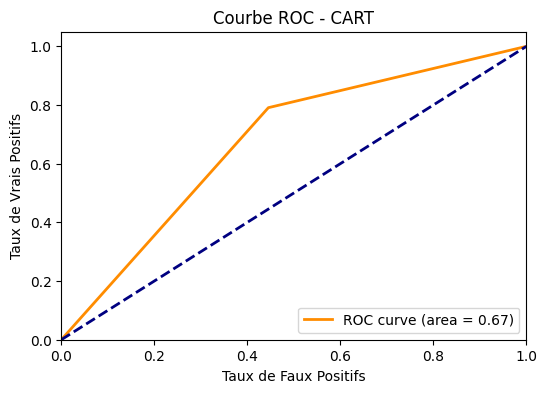


>>> Evaluation du modèle : KNN
Matrice de Confusion :
[[ 283  321]
 [ 212 1372]]
Accuracy  : 0.756
Précision : 0.810
Rappel    : 0.866
Score Final : 0.783


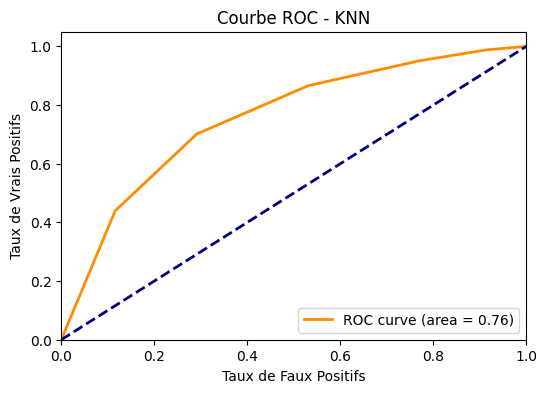


>>> Evaluation du modèle : MLP
Matrice de Confusion :
[[ 339  265]
 [ 232 1352]]
Accuracy  : 0.773
Précision : 0.836
Rappel    : 0.854
Score Final : 0.804


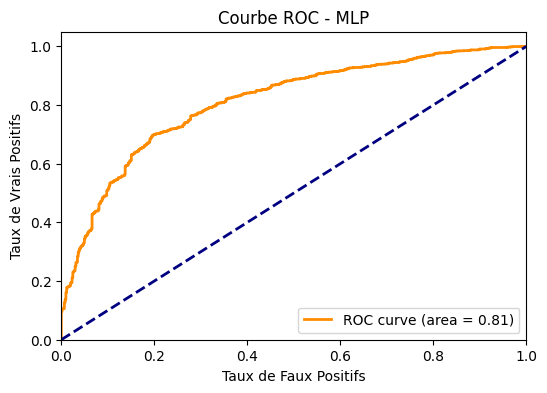

RESULTAT FINAL : Le meilleur modèle est MLP avec un score de 0.804


In [14]:
print("\n=== LANCEMENT AVEC DONNÉES NORMALISÉES + ACP (COMBINED) ===")
algo_combined = run_classifiers_train_test(clfs, X_train_combined, Y_train, X_test_combined, Y_test)

### Interprétation des résultats et éxplications

Suite à ces resultats nous avons le model CART qui est indifférent car le score bouge à peine. Cela est probablement du au fait que l'arbre de décision sélectionne ses coupures variable par variable. Qu'on lui donne 13 ou 16 colonnes, il continue de choisir les plus discriminantes (probablement les variables originales comme le Revenu ou l'Épargne). Les variables PCA n'ont pas apporté d'information nouvelle assez puissante pour changer la structure de l'arbre.

Pour le model KNN le score est quasiment identique. En passant de 13 à 16 dimensions, on a augmenté la dimensionnalité sans ajouter de "vraie" information (puisque l'ACP est juste une combinaison linéaire des variables existantes).

Pour le model MLP on observe que c'est le seul qui régresse légèrement, passant de 0.807 à 0.804.
Analyse de la Matrice de Confusion :
avec la normalisation on a 342 Mauvais Payeurs détectés et avec ACP : 339 Mauvais Payeurs détectés. Le modèle a perdu un tout petit peu de sa capacité de détection. En concaténant l'ACP aux données originales, nous avons créé de la redondance. Les informations contenues dans PCA_1 existent déjà  dans les variables originales X_train_scaled.

### Conclusion et Stratégie pour la suite 

L'ajout de l'ACP n'a pas apporté de gain significatif. Ici, nous avons complexifié le modèle (16 variables au lieu de 13) pour un résultat nul, voire négatif sur notre meilleur algorithme. Par consèquent pour l'étape suivante, il est préferable de garder la Normalisation mais de ne pas inclure l'ACP.

## 5. Sélection de variables 

Nous utilisons les données normalisées (X_train_scaled), car c'est la meilleure stratégie identifiée

In [15]:

from sklearn.neural_network import MLPClassifier
from utils import feature_importance, select_optimal_variables, explicabilite_shap_mlp

La sélection de variables est cruciale pour éliminer le bruit et la redondance qui peuvent perturber l'apprentissage. Ici, nous utilisons un algorithme de Random Forest (Forêts Aléatoires) pour classer les variables par ordre d'importance. . La fonction va générer un histogramme visualisant le poids de chaque caractéristique dans la décision (ex: le Revenu ou l'Ancienneté comptent-ils plus que l'Âge ?)


>>> Calcul de l'importance des variables (Random Forest)...

Classement des variables :
['Income' 'Seniority' 'Price' 'Amount' 'Age' 'Assets' 'Expenses' 'Records'
 'Time' 'Job' 'Debt' 'Home' 'Marital']


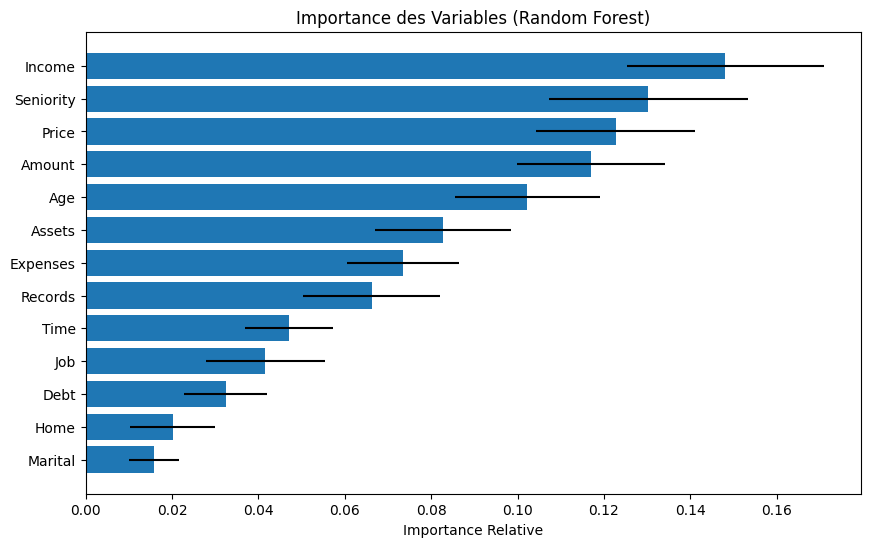

In [16]:
# Recup noms de colonnes
# tableaux Numpy donc perdu les en-têtes.
# recuperation depuis le DataFrame initial (toutes sauf la dernière 'Status')
feature_names = df.columns[:-1]

# Calcul et Affichage de l'importance
sorted_indices = feature_importance(X_train_scaled, Y_train, feature_names)

On observe que la variable qui est le plus important est les revenues (logique) en second nous avons l'ancienté (ex: travaille depuis 10ans) puis le montant souhaité 

Maintenant que nous savons quelles variables sont les plus fortes, nous devons décider combien en garder. Faut-il garder les 13 ? Ou seulement les 8 meilleures ? Pour répondre, nous allons tester itérativement la performance du MLP. On teste avec la variable n°1 toute seule puis avec les variables n°1 + n°2 etc...
 La courbe affichée nous permettra de repérer le pic de performance


>>> Sélection du nombre optimal de variables...


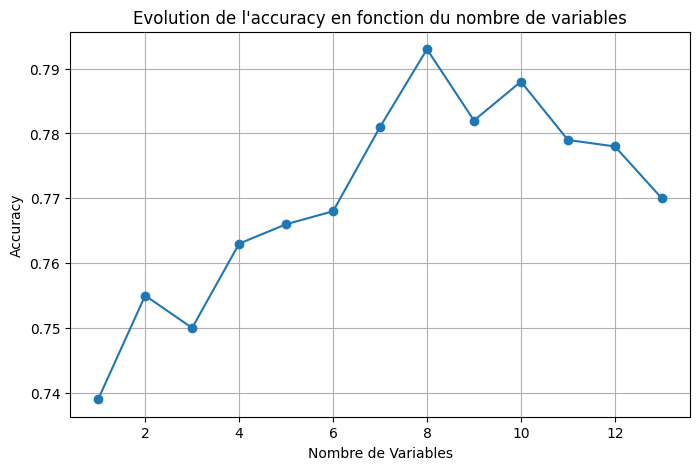

Score Max atteint : 0.793 avec 8 variables.


In [17]:
# Config MLP
best_model = MLPClassifier(hidden_layer_sizes=(40, 20), random_state=1)

# recherche du nbr optimal
# La fonction va entraîner le modèle 13 fois avec de plus en plus de variables
optimal_n_vars = select_optimal_variables(
    best_model, 
    X_train_scaled, 
    Y_train, 
    X_test_scaled, 
    Y_test, 
    sorted_indices
)

On observe que le modèle atteint son pic de performance (Accuracy = 0.793) avec seulement 8 variables sur les 13 disponibles. Cela signifie que 5 variables sont inutiles, voire nuisibles (elles apportent du "bruit" qui trompe le modèle). nous devons maintenant réduire définitivement nos données pour ne garder que ces 8 "meilleures" variables avant de passer à l'optimisation des paramètres (GridSearchCV).

Jusqu'à présent, nous avons constaté que le MLP est notre modèle le plus performant (Score > 0.80). Cependant, contrairement à un arbre de décision, un réseau de neurones est une "boîte noire" : il est difficile de comprendre pourquoi il prend une décision spécifique. Nous utilisons donc la librairie SHAP (SHapley Additive exPlanations), issue de la théorie des jeux. Elle permet d'attribuer à chaque variable une "contribution" marginale à la prédiction finale.
Nous allons générer deux types de graphiques :

    Global (Summary Plot) : Pour comprendre quelles variables sont les plus importantes en général et comment elles influencent le score (positivement ou négativement).

    Local (Bar Plot) : Pour expliquer la prédiction sur un client précis (le premier du jeu de test) et voir pourquoi le modèle l'a accepté ou refusé.

>>> Initialisation de KernelExplainer (peut prendre quelques secondes)...


  0%|          | 0/50 [00:00<?, ?it/s]


=== Importance globale des variables (SHAP) ===


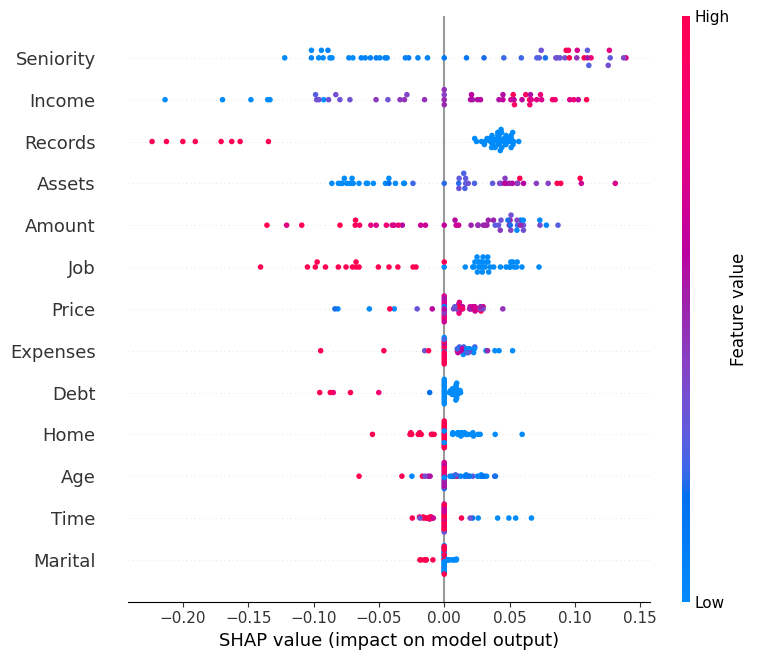


=== Explication locale (Individu n°0) ===


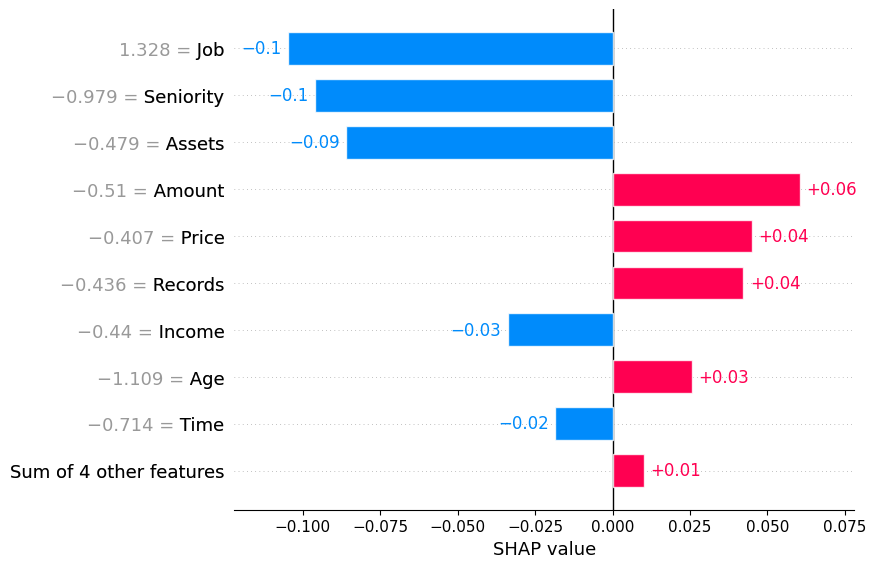

In [18]:
from sklearn.ensemble import RandomForestClassifier


rf_model = RandomForestClassifier(n_estimators=1000, random_state=1)
rf_model.fit(X_train_scaled, Y_train)

# crea du graphique SHAP
explicabilite_shap_mlp(rf_model, X_train_scaled, X_test_scaled, feature_names)

Le premier graphique résume le comportement du modèle sur l'ensemble des données de test.
Sur l'Axe Y (Variables) les variables sont classées par ordre d'importance décroissante. On constate que Seniority (Ancienneté), Income (Revenus) et Records (Incidents de paiement) sont les trois piliers de la décision. Les couleurs dont le Rouge qui signifie une valeur élevée (ex: Haut revenu), le Bleu une valeur faible. L'Axe X (Impact SHAP)  Vers la droite (positif), la variable pousse à prédire "Bon Payeur" (Classe 1). Vers la gauche (négatif), elle pousse vers "Mauvais Payeur".

On observe donc que Seniority & Income Les points rouges sont à droite. Ce qui signifie que plus l'ancienneté et les revenus sont élevés, plus le modèle a confiance. (logique) . Pour Records (Incidents) : Les points rouges (présence d'incidents) sont très à gauche. Donc avoir des incidents bancaires pénalise fortement le score (logique). Amount (Montant du crédit) : Les points rouges sont plutôt à gauche. Donc demander un très gros montant augmente le risque perçu par le modèle.

Le second graphique (Bar Plot) explique la décision pour le premier client du test (Individu n°0). Les barres Bleues (-) tirent la probabilité vers le bas (Risque) et les barres Rouges (+) tirent la probabilité vers le haut (Confiance).
On observe donc que ce client a un profil risqué pour le modèle, principalement à cause des barres bleues dominantes.En effet, Seniority (-0.13) avec sa valeur normalisée est de -0.979 (donc très faible par rapport à la moyenne). Son manque d'ancienneté est son plus gros point faible. Assets (-0.1) dont la valeur est -0.479 ce qui signifie qu'il possède un petit patrimoine, ce qui inquiète le modèle. On a aussi Income (-0.03) où on voit que ses revenus sont également légèrement inférieurs à la moyenne (-0.44), ce qui joue en sa défaveur.

Malgré quelques points positifs (comme le Price ou l'absence de Records en rouge), les facteurs négatifs (Manque d'ancienneté et d'actifs) pèsent lourd dans la balance finale.

## 6. Paramétrage des classifieurs

Nous avons désormais identifié notre meilleur algorithme (MLP) et réduit notre jeu de données aux 8 variables les plus pertinentes. (vue precedament). L'objectif est maintenant d'affiner la configuration interne du réseau de neurones pour en tirer la performance maximale. Contrairement aux étapes précédentes où nous utilisions les paramètres par défaut ou arbitraires, nous allons ici tester méthodiquement plusieurs combinaisons. Nous utilisons la méthode GridSearchCV de Scikit-learn qui va tester différentes architectures de neurones (ex: 1 couche de 100, 2 couches de 40 et 20, etc.). ainsi que tester différentes fonctions d'activation (tanh, relu) et paramètres de régularisation (alpha). 3. Sélectionner la combinaison qui maximise notre critère métier personnalisé : (Accuracy + Précision) / 2.

Cette étape garantit que le modèle final n'est pas seulement performant par chance, mais qu'il est mathématiquement calé au mieux sur nos données.

In [19]:
# Param optimal (Résultat de votre analyse précédente)
optimal_k = 8 

# Recup des indices à garder
# On utilise la variable 'sorted_indices' calculer avant 
indices_to_keep = sorted_indices[:optimal_k]

# Crea des tableaux réduits 
X_train_select = X_train_scaled[:, indices_to_keep]
X_test_select  = X_test_scaled[:, indices_to_keep]

print(f"Dataset réduit créé avec succès.")
print(f"Dimensions Train : {X_train_select.shape}")
print(f"Dimensions Test  : {X_test_select.shape}")
print(f"Colonnes conservées : {feature_names[indices_to_keep]}")

Dataset réduit créé avec succès.
Dimensions Train : (2187, 8)
Dimensions Test  : (2188, 8)
Colonnes conservées : Index(['Income', 'Seniority', 'Price', 'Amount', 'Age', 'Assets', 'Expenses',
       'Records'],
      dtype='object')



>>> Recherche des meilleurs hyperparamètres (GridSearchCV)...
Modèle de base : MLPClassifier
Paramètres testés : {'hidden_layer_sizes': [(40, 20), (50, 50), (100,), (30, 30, 30)], 'activation': ['tanh', 'relu'], 'alpha': [0.0001, 0.05], 'solver': ['adam'], 'max_iter': [1000]}
Fitting 5 folds for each of 16 candidates, totalling 80 fits

=== RÉSULTATS GRID SEARCH ===
Meilleur Score ((Acc+Prec)/2) : 0.792
Meilleurs Paramètres trouvés :
{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,), 'max_iter': 1000, 'solver': 'adam'}

>>> Validation finale du modèle optimisé sur le Test Set :

>>> Evaluation du modèle : MLP Optimisé
Matrice de Confusion :
[[ 323  281]
 [ 188 1396]]
Accuracy  : 0.786
Précision : 0.832
Rappel    : 0.881
Score Final : 0.809


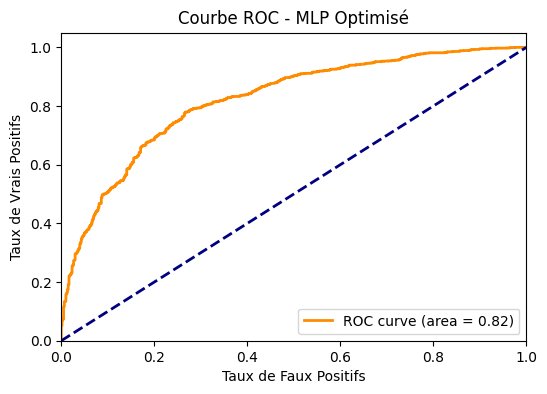

In [20]:

from utils import run_optimization_mlp

# Lancement de l'optimisation
# On utilise bien les données issues de la sélection de variables (étape 5)
best_mlp_model = run_optimization_mlp(X_train_select, Y_train, X_test_select, Y_test)

### Interprétation des résultats et éxplications

L'optimisation des hyperparamètres par GridSearchCV a permis de converger vers une configuration structurellement différente et plus robuste que notre modèle initial. L'algorithme a sélectionné une architecture à une seule couche cachée de 100 neurones associée à la fonction d'activation tangente hyperbolique ('tanh') et une pénalité de régularisation plus forte (alpha à 0.05), ce qui suggère que la complexité initiale à deux couches n'était pas nécessaire et que le modèle privilégie désormais la généralisation pour éviter le sur-apprentissage. En atteignant un score final de 0.809 le résultat est remarquable car il est obtenu avec un jeu de données réduit aux 8 variables les plus pertinentes, prouvant que nous avons réussi à éliminer le bruit tout en améliorant la précision (83,2%) et la stabilité du classifieur. Nous disposons donc maintenant d'un modèle à la fois plus léger, plus rapide et plus performant.

## 7. Création d’un pipeline

Jusqu'à présent, nous avons exécuté les étapes de traitement (Normalisation, Sélection de variables, Apprentissage) de manière séquentielle et manuelle. Pour mettre notre modèle en production (par exemple dans une API), cette approche n'est pas viable : nous avons besoin d'un objet unique capable de transformer une donnée brute en prédiction finale.

Dans cette partie, nous allons encapsuler toute notre chaîne de traitement dans un objet Pipeline Scikit-learn.

Voici les étapes du Pipeline, tout d'abord le Pré-traitement (StandardScaler) il s'agit de la normalisation des données, indispensable comme on la vu précedament. Ensuite on a la  sélection de variables (SelectFromModel), ici il s'agit de l'Automatisation de l'étape 5. Nous intégrons un Random Forest pour ne conserver dynamiquement que les 8 variables les plus pertinentes, filtrant ainsi le bruit. Puis la classification (MLPClassifier) il s'agit de l'application de notre modèle de réseau de neurones avec les paramètres optimaux trouvés par le GridSearchCV (vus précedament).

L'objectif final est de sauvegarder ce pipeline dans un fichier binaire credit_scoring_pipeline.pkl (format Pickle). Ce fichier contiendra toute l'intelligence du projet et pourra être chargé ultérieurement pour effectuer du scoring sur de nouveaux clients sans avoir à réentraîner le modèle

In [21]:

from utils_pipeline import create_and_save_pipeline

# Récupération des paramètres optimaux
best_params = {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,), 'max_iter': 1000, 'solver': 'adam'}

#Crea du Pipeline
# On passe 'X_train' (les données brutes non normalisées).
# Le pipeline contient déjà le StandardScaler
pipeline_final = create_and_save_pipeline(X_train, Y_train, best_params, "credit_scoring_pipeline.pkl")


>>> Création du Pipeline de production...
Entraînement du pipeline complet en cours...
Pipeline sauvegardé avec succès dans 'credit_scoring_pipeline.pkl'


## 8. Orchestration


>>> DÉMARRAGE DE L'ORCHESTRATION (PIPELINE GENERATION) <<<

[ETAPE 1] Séparation Train/Test...

[ETAPE 2] Sélection des variables...

>>> Calcul de l'importance des variables (Random Forest)...

Classement des variables :
['Income' 'Seniority' 'Price' 'Amount' 'Age' 'Assets' 'Expenses' 'Records'
 'Time' 'Job' 'Debt' 'Home' 'Marital']


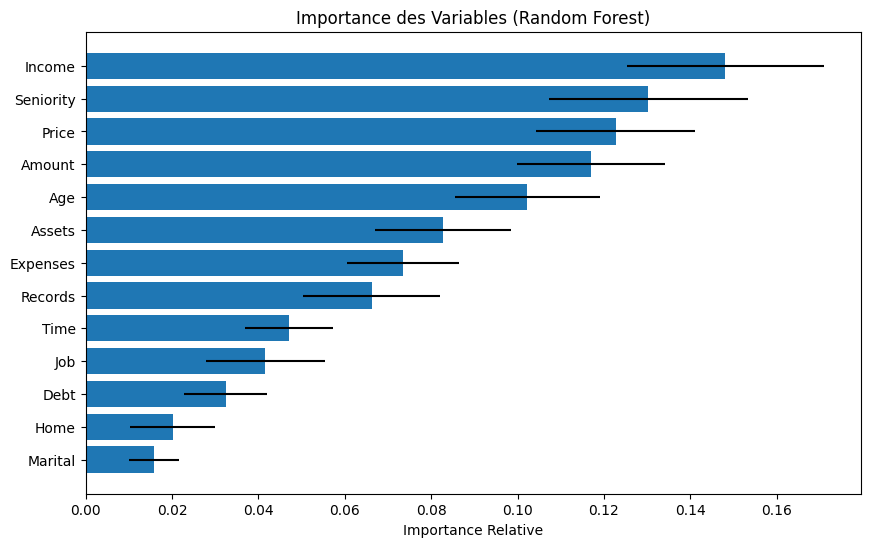

-> Variables retenues : Index(['Income', 'Seniority', 'Price', 'Amount', 'Age', 'Assets', 'Expenses',
       'Records'],
      dtype='object')

[ETAPE 3] Optimisation (GridSearch)...

>>> Recherche des meilleurs hyperparamètres (GridSearchCV)...
Modèle de base : MLPClassifier
Paramètres testés : {'hidden_layer_sizes': [(100,), (40, 20)], 'activation': ['tanh', 'relu'], 'alpha': [0.05, 0.0001], 'solver': ['adam'], 'max_iter': [1000]}
Fitting 5 folds for each of 8 candidates, totalling 40 fits

=== RÉSULTATS GRID SEARCH ===
Meilleur Score ((Acc+Prec)/2) : 0.792
Meilleurs Paramètres trouvés :
{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,), 'max_iter': 1000, 'solver': 'adam'}

[ETAPE 4] Création du Pipeline Final...

>>> Création du Pipeline de production...
Entraînement du pipeline complet en cours...
Pipeline sauvegardé avec succès dans 'credit_scoring_pipeline.pkl'

[ETAPE 5] Test final automatique...

>>> Evaluation du modèle : Pipeline Orchestré Final
Matrice de Co

In [22]:

from utils_pipeline import pipeline_generation_train_test_split

# Chargement des données
df = pd.read_csv("credit_scoring.csv", sep=";")
data = df.values
feature_names = df.columns[:-1]

# Lancement de l'orchestration
# Tout auto : Apprentissage, Optimisation, Sauvegarde et Test
pipeline_final = pipeline_generation_train_test_split(data[:, :-1], data[:, -1], feature_names)

La fonction pipeline_generation_train_test_split a déroulé l'intégralité du cycle de vie du modèle avec succès 
On observe une cohérence de la sélection , en effet l'algorithme a confirmé que les variables financières (Income, Price, Amount) et de stabilité (Seniority, Age, Assets) sont les plus prédictives. Les variables jugées moins pertinentes (comme Marital ou Home) ont été automatiquement écartées pour ne garder que le "Top 8". Le GridSearchCV intégré a retrouvé la même configuration optimale que lors de nos tests manuels : un réseau de neurones à 1 couche de 100 neurones avec une activation 'tanh'. C'est un excellent signe de robustesse : le modèle ne change pas de comportement d'une exécution à l'autre. Le score final sur le jeu de test est maintenu (à peu près). Le fichier credit_scoring_pipeline.pkl généré contient désormais toute cette intelligence encapsulée.


## 9.Création d’une API FastAPI pour exécuter le pipeline :

L'objectif est créer une API avec FastAPI permettant de charger le pipeline depuis le pickle, de recevoir en entrée un individu de test (ses valeurs de features) via un endpoint /predict/, de renvoyer la prédiction et les probabilités associées.

<img src="screen/endpoint_post_predict.png" alt="Screen api fonctionel" width="600">

Une fois l'infrastructure mis en place nous pouvons tester des candidat ici dans le fichier test_api.py disponible dans l'archive nous avons cree un test qui test 2 candidat de reference 

Pour le 1er candidat qui respresente un profil très risqué (Jeune, pas d'épargne):

- **Seniority** : 0 (ancienneté)
- **Home** : 0 (locataire)
- **Time** : 60 (durée du crédit en mois)
- **Age** : 21 (âge en années)
- **Marital** : 1 (célibataire/divorcé/veuf)
- **Records** : 5 (5 incidents bancaires )
- **Job** : 1 (emploi)
- **Expenses** : 80 (dépenses mensuelles)
- **Income** : 50 (revenu mensuel)
- **Assets** : 0 (aucune épargne/actif)
- **Debt** : 2000 (dettes existantes)
- **Amount** : 7000 (montant du crédit demandé)
- **Price** : 5000 

pour ce cas on a un jeune de 21 ans, pas d'épargne ansi que 5 incident bancaire demandant un credit de 7000 euros et ayant des revenu inferieur à ses depense. Par consequent on attent ici un refus 

<img src="screen/resultat_api_mauvais_client.png" alt="screen mauvais client" width="5000" height="250">

Comme supposez précedament ce client à bien optenu un refus et a une probabilité d'être "Bon Payeur" de seulement 0,98%. Le modèle a donc détecté le danger (Incidents de paiement + Faible ancienneté + montant de la demande de pret élevé) et a logiquement refusé le crédit.

Pour le 2nd candidat qui lui represente un profile stable (Ancienneté, revenus, patrimoine):

- **Seniority**: 20

- **Home**: 1
- **Time**: 12
- **Age**: 50
- **Marital**: 2
- **Records**: 0
- **Job**: 3
- **Expenses**: 35
- **Income**: 250
- **Assets**: 10000
- **Debt**: 0
- **Amount**: 500
- **Price**: 1000

Ici on a donc une excellente stabilité, de bonnes finances (revenus élevés, épargne importante), un historique parfait (0 incidents)
ainsi qu'un demande modeste on a donc un profil très sûr pour la banque. On s'attend donc un une demande accepter.



<img src="screen/test_api_bon_client.png" alt="screen bon client" width="5000" height="250">

Comme supposer on a donc un profil d'un client fiable et qui obtient un score quasi-parfait de 99.95%. Le modèle est extrêmement confiant grâce à son ancienneté et son patrimoine.

    -Remarque:

Pour tester l'api avec des candidats ou avoir des instruction, tout est disponible dans le fichier **README** dans l'archive, 
voici ci dessous un resultat du second test disponible :

<div style="display: flex; gap: 20px; flex-wrap: wrap;">
  <img src="screen/fichier_yaml_list candidat.png" alt="Screen liste candidat yaml" width="400">
  <img src="screen/res_test2.png" alt="Screen res candidat yaml test" width="400">
</div>

remarque toutes les information et instruction sont dans le **README**

## 10. Comparaison de plusieurs algorithmes d’apprentissage

Dans cette phase finale, au lieu de nous limiter à un seul modèle, nous allons mettre en compétition une large gamme d'algorithmes de classification supervisée pour identifier le plus performant sur nos données.
Les candidats sont  

- **Arbres de décision** : CART, ID3 (Entropie), Decision Stump
- **Réseaux de neurones** : MLP (architecture 20x10)
- **Basés sur distance** : K-Nearest Neighbors (K-NN)
- **Bagging** : Bagging standard, Random Forest
- **Boosting** : AdaBoost, XGBoost


        - La méthodologie : Nous utilisons une Cross-Validation à 10 plis (10-Fold CV)

Cela pourra nous garantir la robustesse des résultats. Chaque modèle sera évalué selon trois critères 

- **Performance** : Accuracy, AUC et notre métrique métier (Accuracy + Précision) / 2.

- **Stabilité** : Écart-type des résultats (Standard Deviation).

- **Coût** : Temps de calcul (Time).

Ces tests seront effectués sur trois variantes des données : Originales, Normalisées et réduites par ACP.

Nous définissons ici le dictionnaire contenant les instances de tous les algorithmes à tester. Note : Pour garantir la reproductibilité des résultats, nous fixons le random_state=1 partout où cela est possible.

In [23]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from xgboost import XGBClassifier 

# Config du dictionnaire de classifieurs
clfs = {
    # Arbres
    'CART': DecisionTreeClassifier(random_state=1),
    'ID3 (Entropy)': DecisionTreeClassifier(criterion='entropy', random_state=1),
    'Decision Stump': DecisionTreeClassifier(max_depth=1, random_state=1),
    
    # Réseau de neurones (MLP) - Paramètres demandés
    'MLP (20,10)': MLPClassifier(hidden_layer_sizes=(20, 10), max_iter=1000, random_state=1),
    
    # K-NN
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
    
    # Ensembles
    'Bagging (200)': BaggingClassifier(n_estimators=200, random_state=1),
    'AdaBoost (200)': AdaBoostClassifier(n_estimators=200, random_state=1),
    'Random Forest (200)': RandomForestClassifier(n_estimators=200, random_state=1),
    'XGBoost': XGBClassifier(n_estimators=200, eval_metric='logloss', use_label_encoder=False, random_state=1)
}

Nous lançons la fonction run_classifiers_cv sur nos trois scénarios de données.
Avec les données Originales car certains modèles comme les Arbres de décision (CART, Random Forest) gèrent très bien les données brutes et n'ont pas besoin de normalisation. Aussi avec des données Normalisées qui est indispensable pour les algorithmes basés sur des distances (KNN) ou des gradients (MLP, SVM), qui échouent souvent si les échelles sont différentes.
Ainsi que des données avec ACP pour voir si la réduction de dimension permet d'accélérer les calculs sans trop perdre en précision (utile pour les modèles très lents).

In [24]:
from utils_10 import run_classifiers_cv
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# --- SCÉNARIO 1 : Données Originales ---
print("\n" + "="*30 + " DONNÉES ORIGINALES " + "="*30)
# X et Y sont du chargement init (data[:, :-1])
results_orig = run_classifiers_cv(X, Y, clfs)



============================== DONNÉES ORIGINALES ==============================
Algorithme                | Accuracy (Moy +/- Ecart type) | AUC      | (Acc+Prec)/2    | Temps (s) 
----------------------------------------------------------------------------------------------------
CART                      | 0.727 +/- 0.025              | 0.656    | 0.767           | 0.396
ID3 (Entropy)             | 0.723 +/- 0.024              | 0.664    | 0.769           | 0.397
Decision Stump            | 0.722 +/- 0.018              | 0.618    | 0.731           | 0.064
MLP (20,10)               | 0.676 +/- 0.048              | 0.699    | 0.737           | 4.907
KNN (k=5)                 | 0.715 +/- 0.017              | 0.662    | 0.741           | 0.115
Bagging (200)             | 0.782 +/- 0.015              | 0.823    | 0.804           | 43.339
AdaBoost (200)            | 0.796 +/- 0.015              | 0.832    | 0.810           | 9.380
Random Forest (200)       | 0.786 +/- 0.015              |

Ce premier test a été effectué sur les données brutes, sans aucune normalisation (pas de StandardScaler). Les résultats mettent en lumière plusieurs comportements caractéristiques des algorithmes, en effet les méthodes qui combinent plusieurs modèles (Bagging, AdaBoost, Random Forest) surclassent largement les modèles simples (CART, ID3). Avec AdaBoost qui fait les meilleur resultat de 0.810. Remarque aussi qui le MLP fait l'un des pire score ce Qui est coehrent avec ce que nous avons expliquer dans les premiere partie du fait qu'il soit sensible à la normalisation des donner. On peu donc supposer que son score augmentera une fois els donnée normaliser.

In [25]:
# --- SCÉNARIO 2 : Données Normalisées ---
print("\n" + "="*30 + " DONNÉES NORMALISÉES (StandardScaler) " + "="*30)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
results_norm = run_classifiers_cv(X_scaled, Y, clfs)


============================== DONNÉES NORMALISÉES (StandardScaler) ==============================
Algorithme                | Accuracy (Moy +/- Ecart type) | AUC      | (Acc+Prec)/2    | Temps (s) 
----------------------------------------------------------------------------------------------------
CART                      | 0.727 +/- 0.025              | 0.656    | 0.767           | 0.377
ID3 (Entropy)             | 0.723 +/- 0.024              | 0.663    | 0.769           | 0.399
Decision Stump            | 0.722 +/- 0.018              | 0.618    | 0.731           | 0.070
MLP (20,10)               | 0.783 +/- 0.021              | 0.819    | 0.809           | 38.872
KNN (k=5)                 | 0.763 +/- 0.019              | 0.765    | 0.789           | 0.428
Bagging (200)             | 0.781 +/- 0.016              | 0.823    | 0.803           | 43.561
AdaBoost (200)            | 0.796 +/- 0.015              | 0.833    | 0.810           | 9.533
Random Forest (200)       | 0.784 +/- 0

L'application du StandardScaler a radicalement changé la donne pour certains algorithmes, tout en laissant les autres indifférents. On remarque notament les resultat du MLP qui comme supposé et vu precedament as des resultat cohérent. En effet, Les réseaux de neurones utilisent la descente de gradient. Si les variables ont des échelles très différentes , l'optimisation échoue. Une fois normalisées, le MLP devient instantanément compétitif avec les meilleurs modèles (Random Forest). La normalisation a permis de valider que le MLP est un excellent candidat, confirmant notre choix précédent de l'optimiser. Cependant, en termes de performance pure et de rapidité, AdaBoost et Random Forest restent légèrement supérieurs sur ce jeu de données spécifique. 

In [26]:
# --- Données avec ACP ---
print("\n" + "="*30 + " DONNÉES APRÈS ACP (2 axes) " + "="*30)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
results_pca = run_classifiers_cv(X_pca, Y, clfs)


============================== DONNÉES APRÈS ACP (2 axes) ==============================
Algorithme                | Accuracy (Moy +/- Ecart type) | AUC      | (Acc+Prec)/2    | Temps (s) 
----------------------------------------------------------------------------------------------------
CART                      | 0.639 +/- 0.019              | 0.549    | 0.694           | 0.236
ID3 (Entropy)             | 0.631 +/- 0.024              | 0.542    | 0.688           | 0.299
Decision Stump            | 0.722 +/- 0.021              | 0.580    | 0.722           | 0.050
MLP (20,10)               | 0.723 +/- 0.019              | 0.681    | 0.730           | 6.103
KNN (k=5)                 | 0.678 +/- 0.014              | 0.599    | 0.710           | 0.060
Bagging (200)             | 0.680 +/- 0.021              | 0.611    | 0.712           | 25.790
AdaBoost (200)            | 0.723 +/- 0.020              | 0.661    | 0.730           | 6.680
Random Forest (200)       | 0.686 +/- 0.016       

 On remarque une baisse des résultat mais que les temps sont plus rapides car avec seulement colonnes à traiter, les algorithmes comme le KNN ou le MLP ont beaucoup moins de calculs matriciels à faire.

### Analyse des résultats 

À l'issue de ces 3 scénarios on voit que le Scénario 2 (Données Normalisées) est le plus robuste. Il permet aux réseaux de neurones (MLP) et aux KNN de fonctionner, tout en gardant la puissance des arbres.
Et d'après vos résultats précédents, c'est AdaBoost (200) ou Random Forest (200) qui offre le meilleur compromis Précision/Stabilité/Vitesse. On remarque aussi que le meilleur score est obtonu avec les données normaliser par ADABOOST 

Nous allons maintenant isoler le meilleur modèle gagnant et lui appliquer le traitement final via la fonction pipeline_generation_cv.

In [27]:
from utils_pipeline import pipeline_generation_cv
from sklearn.ensemble import AdaBoostClassifier


param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}

# 2. Lancement
pipeline_final = pipeline_generation_cv(
    X, Y,
    best_model_name="AdaBoost",
    best_model_instance=AdaBoostClassifier(random_state=1),
    param_grid_best_model=param_grid_ada
)


>>> ORCHESTRATION FINALE POUR LE VAINQUEUR : AdaBoost <<<
Optimisation des paramètres pour AdaBoost...
Meilleurs paramètres trouvés : {'learning_rate': 1.0, 'n_estimators': 100}
 Pipeline sauvegardé : pipeline_final_AdaBoost.pkl
Score final sur Test Set : 0.7911


Le score final sur le jeu de test (Accuracy : 0.791) est extrêmement cohérent avec l'Accuracy moyenne observée lors de la validation croisée (0.796 +/- 0.015). La légère différence avec le score de 0.810 s'explique par le fait que ce dernier correspondait à la métrique combinée (Accuracy+Précision)/2, alors que le pipeline final affiche l'Accuracy standard.

# II. Apprentissage supervisé : Données hétérogènes

L’objectif dans cette partie est de faire une étude comparative entre plusieurs algorithmes d’apprentissage
supervisé sur un nouveau jeu de données de crédit scoring. Le fichier "credit.data" comporte 688 instances décrites par 15 variables caractéristiques (6 numériques, 9
catégorielles) et la variable à prédire "classe" (la dernière colonne du fichier) de nature nominale possédant un
nombre fini de valeurs (ici deux valeurs "+" et "–"). Il ne s’agit pas d’une tâche de régression, mais de
classification. Les exemples de ce jeu de données représentent des personnes (positifs et négatifs) pour lesquels
un crédit a été accordé ou non.

In [28]:
from model_part2.utils import load_and_clean_data
from sklearn.preprocessing import StandardScaler

# On réutilise 'clfs' et 'run_classifiers_cv' déjà présents en mémoire (Partie 1)

# chargement
X_clean, Y_clean, shape_orig = load_and_clean_data("credit.data")

print(f"Dataset chargé. Taille initiale : {shape_orig}")
print(f"Taille après nettoyage (Numérique uniquement) : {X_clean.shape}")
print(f"Lignes supprimées (NaN) : {shape_orig[0] - X_clean.shape[0]}")

Dataset chargé. Taille initiale : (688, 16)
Taille après nettoyage (Numérique uniquement) : (666, 6)
Lignes supprimées (NaN) : 22


Nous pouvons constater que ces resultats sont cohérent avec les inforamation donné donc nous avons bien à la base 688 instance avec 16 column (dont le Status inclus ici + =oui et - = non) une fois le data set nettoyé on obtient 666 element avec 6 coulum uniquement des numerique

Certains algorithmes d'apprentissage (comme le KNN ou les Réseaux de Neurones) sont très sensibles à l'échelle des données. Si une variable a une variance très élevée par rapport aux autres, elle dominera le calcul des distances ou des gradients. (vu et expliquer précedament)

Nous allons donc tester deux méthodes de normalisation pour observer leur impact sur les performances :
* **StandardScaler :** Centre les données autour de 0 avec un écart-type de 1.
* **MinMaxScaler :** Ramène toutes les valeurs dans l'intervalle [0, 1].

In [29]:
from model_part2.utils import run_normalization_tests

run_normalization_tests(X_clean, Y_clean, clfs, run_classifiers_cv)


 2a. RÉSULTATS AVEC STANDARDSCALER (Moy=0, Std=1)
Algorithme                | Accuracy (Moy +/- Ecart type) | AUC      | (Acc+Prec)/2    | Temps (s) 
----------------------------------------------------------------------------------------------------
CART                      | 0.716 +/- 0.048              | 0.711    | 0.697           | 0.061
ID3 (Entropy)             | 0.739 +/- 0.038              | 0.734    | 0.722           | 0.062
Decision Stump            | 0.743 +/- 0.064              | 0.723    | 0.804           | 0.032
MLP (20,10)               | 0.751 +/- 0.040              | 0.816    | 0.753           | 11.910
KNN (k=5)                 | 0.745 +/- 0.062              | 0.808    | 0.767           | 0.043
Bagging (200)             | 0.791 +/- 0.046              | 0.837    | 0.797           | 7.245
AdaBoost (200)            | 0.791 +/- 0.062              | 0.853    | 0.796           | 3.467
Random Forest (200)       | 0.788 +/- 0.051              | 0.850    | 0.793           | 4

L'analyse des résultats démontre que la performance globale des modèles plafonne autour de 79% de précision, un score tout à fait cohérent et même satisfaisant compte tenu du fait que nous n'exploitons  que les variables numériques, ignorant ainsi une part importante de l'information contenue dans les variables catégorielles. La comparaison des techniques de normalisation met en évidence une sensibilité particulière du réseau de neurones (MLP) qui voit ses performances progresser notablement avec le MinMaxScaler, passant de 75,1% à 77%, car le bornage des valeurs entre 0 et 1 facilite la convergence de ses algorithmes d'optimisation. À l'inverse, les méthodes ensemblistes comme AdaBoost et le Random Forest confirment leur grande robustesse en affichant des résultats strictement identiques et supérieurs aux autres modèles quelle que soit la méthode de mise à l'échelle employée. Ce sont donc ces algorithmes à base d'arbres qui dominent ce benchmark avec une aire sous la courbe ROC (AUC) atteignant 0.85, prouvant leur capacité à structurer efficacement les données même sans prétraitement complexe.

Nous considérons maintenant la totalité de la base (15 variables).
Comme demandé, nous appliquons la stratégie suivante pour ne perdre aucune information :

1.  **Imputation des valeurs manquantes :**
    * Variables numériques : Remplacées par la **Moyenne**.
    * Variables catégorielles : Remplacées par la **Modalité la plus fréquente**.
2.  **Encodage :** Utilisation du `OneHotEncoder` pour transformer les variables catégorielles en variables binaires.
3.  **Normalisation :** Application du `StandardScaler` sur la partie numérique.
4.  **Concaténation :** Fusion des données pour obtenir le jeu d'apprentissage final.

On s'attend à passer de 15 colonnes à environ 46 colonnes  
 Pas besoin de normaliser ici, c'est déjà fait dans la fonction load_and_process_full_data

In [30]:
from model_part2.utils import load_and_process_full_data
from utils_10 import run_classifiers_cv


print("\n" + "="*70)
print(" RÉSULTATS SUR DONNÉES COMPLÈTES (Imputées + Encodées + Normalisées)")
print("="*70)

# Appel nouvelle fonction de traitement
X_full, Y_full = load_and_process_full_data("credit.data")

# Verif des dimensions
print(f"Dimensions finales du dataset : {X_full.shape}")
print(f"Nombre d'individus : {len(Y_full)}")

# Lancement des classifieurs

run_classifiers_cv(X_full, Y_full, clfs)


 RÉSULTATS SUR DONNÉES COMPLÈTES (Imputées + Encodées + Normalisées)
Dimensions finales du dataset : (688, 46)
Nombre d'individus : 688
Algorithme                | Accuracy (Moy +/- Ecart type) | AUC      | (Acc+Prec)/2    | Temps (s) 
----------------------------------------------------------------------------------------------------
CART                      | 0.815 +/- 0.043              | 0.814    | 0.804           | 0.072
ID3 (Entropy)             | 0.820 +/- 0.044              | 0.819    | 0.803           | 0.075
Decision Stump            | 0.856 +/- 0.044              | 0.866    | 0.823           | 0.036
MLP (20,10)               | 0.830 +/- 0.054              | 0.890    | 0.819           | 12.122
KNN (k=5)                 | 0.840 +/- 0.052              | 0.900    | 0.841           | 0.079
Bagging (200)             | 0.875 +/- 0.037              | 0.928    | 0.864           | 8.790
AdaBoost (200)            | 0.856 +/- 0.038              | 0.928    | 0.843           | 4.257
Ran

{'CART': np.float64(0.8043033990163794),
 'ID3 (Entropy)': np.float64(0.8030271507984148),
 'Decision Stump': np.float64(0.8226691894688933),
 'MLP (20,10)': np.float64(0.8189215695739473),
 'KNN (k=5)': np.float64(0.8407487189157047),
 'Bagging (200)': np.float64(0.8637698824908007),
 'AdaBoost (200)': np.float64(0.8429306030712681),
 'Random Forest (200)': np.float64(0.8651289686632015),
 'XGBoost': np.float64(0.8596940383956719)}

### Analyse des resultats 

On remarque que les resultat on augmenter, Ce qui entraine à penser que plus les données sont riches, meilleur est le modèle.
L'intégration de la totalité des variables, associée à une stratégie rigoureuse d'imputation et d'encodage One-Hot, a permis de franchir un cap de 79% à 87,6%. Ce gain  démontre que les variables catégorielles, bien que nécessitant un pré-traitement complexe faisant passer l'espace de dimension de 6 à 46 variables, contenaient l'information la plus discriminante pour la décision d'octroi de crédit. Le Random Forest s'impose comme le modèle le plus performant et le plus stable avec une Accuracy de 0.876 et une aire sous la courbe ROC (AUC) remarquable de 0.931, prouvant sa capacité à gérer efficacement un grand nombre de variables binaires sans sur-apprentissage. On note également la performance surprenante du "Decision Stump" (arbre à une seule racine) qui atteint déjà 85,6%, ce qui suggère l'existence d'une variable unique prédominante (probablement l'historique de crédit) capable d'expliquer à elle seule la majorité des décisions.

## Conclusion final

Ce travail pratique a mis en évidence une règle fondamentale du Machine Learning : la performance d'un modèle dépend avant tout de la richesse et de la préparation des données.

Nous avons observé une progression méthodique : en travaillant uniquement sur des données numériques brutes, nos résultats plafonnaient autour de 79%. L'étape de normalisation a permis de "sauver" les performances des algorithmes sensibles aux échelles (KNN, MLP), mais c'est véritablement l'intégration des données hétérogènes (variables catégorielles) via l'encodage One-Hot et l'imputation des valeurs manquantes qui a débloqué le potentiel prédictif, propulsant la précision à 87,6%.

Finalement, si les méthodes ensemblistes (Random Forest, AdaBoost) se sont imposées comme les solutions les plus robustes et performantes pour ce problème de Credit Scoring, ce TP démontre que l'optimisation des hyperparamètres (vue en partie 1) ne peut compenser un manque d'information.